<a href="https://colab.research.google.com/github/adiba82001/CSE475_project/blob/main/Final_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Import VGG16
from tensorflow.keras import Model, layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from google.colab import drive
from sklearn.metrics import ConfusionMatrixDisplay  # Import for newer scikit-learn versions

In [ ]:

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Set directory paths
M_DIR = "/content/drive/MyDrive/Monkey_Pox_Dataset/Data/Monkeypox/"
O_DIR = "/content/drive/MyDrive/Monkey_Pox_Dataset/Data/Others/"

In [ ]:
# Step 3: Load images from directories
Mimages = os.listdir(M_DIR)
Oimages = os.listdir(O_DIR)

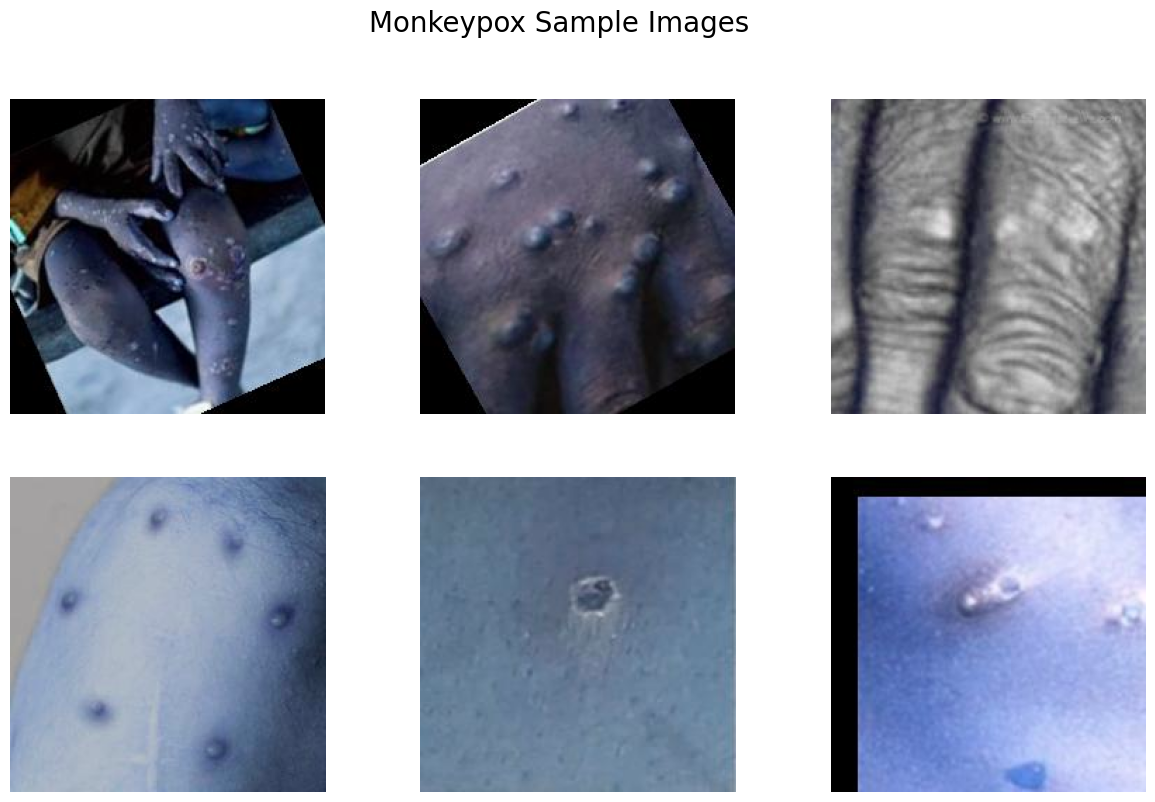

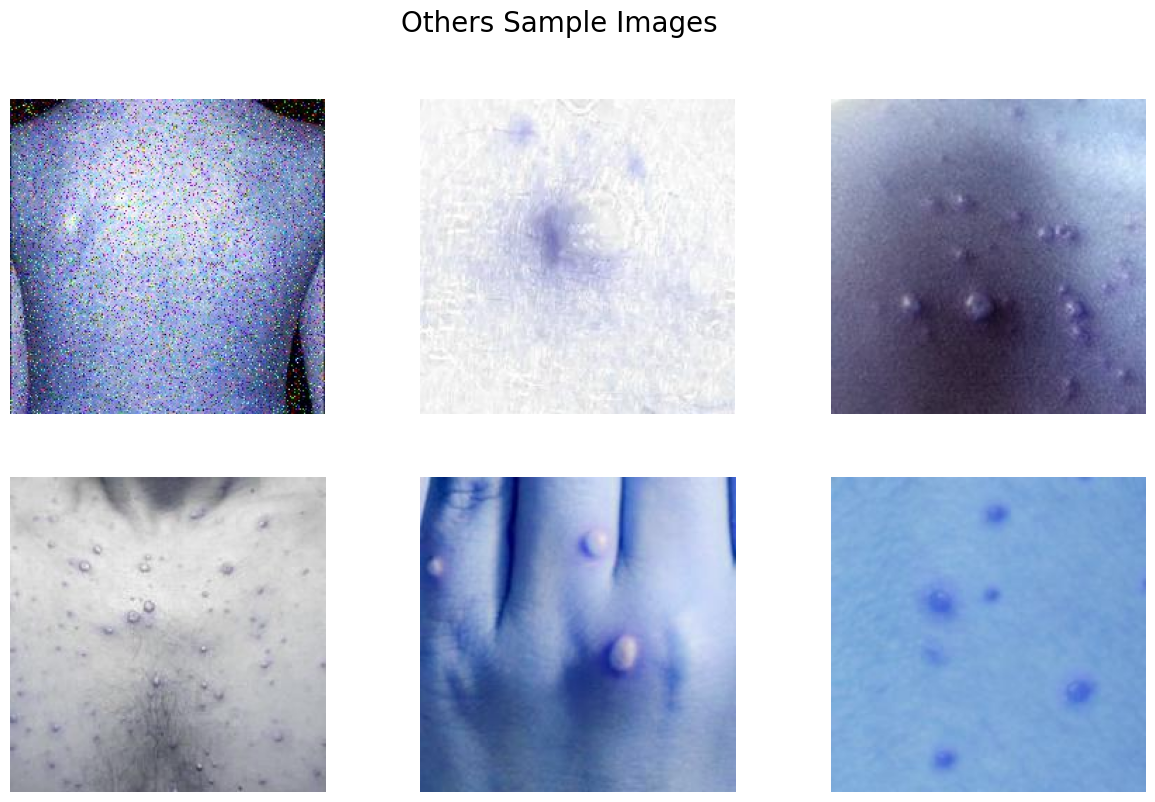

In [ ]:
# Step 4: Display sample images
sample_monkeypox = random.sample(Mimages, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))
for i in range(6):
    im = cv2.imread(M_DIR + sample_monkeypox[i])
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')
f.suptitle('Monkeypox Sample Images', fontsize=20)
plt.show()

sample_others = random.sample(Oimages, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))
for i in range(6):
    im = cv2.imread(O_DIR + sample_others[i])
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')
f.suptitle('Others Sample Images', fontsize=20)
plt.show()

In [ ]:
# Step 5: Prepare the dataset
data = []
labels = []
for m in Mimages:
    try:
        image = cv2.imread(M_DIR + m)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)  # Label 1 for Monkeypox
    except AttributeError:
        print("")

for o in Oimages:
    try:
        image = cv2.imread(O_DIR + o)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)  # Label 0 for Others
    except AttributeError:
        print("")


In [ ]:
feats = np.array(data)
labels = np.array(labels)

# Save the features and labels for later re-use
np.save("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_data", feats)
np.save("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_data", labels)

feats = np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_data.npy")
labels = np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_data.npy")
# Shuffle the dataset
s = np.arange(feats.shape[0])
np.random.shuffle(s)
feats, labels = feats[s], labels[s]

# One-hot encoding for labels
num_classes = len(np.unique(labels))

In [ ]:
# Step 6: Split the dataset into train, validation, and test sets
split_1 = int(0.7 * len(feats))  # 70% for training
split_2 = int(0.85 * len(feats))  # 15% for validation, 15% for test

x_train = feats[:split_1].astype('float32') / 255
x_val = feats[split_1:split_2].astype('float32') / 255
x_test = feats[split_2:].astype('float32') / 255

y_train = to_categorical(labels[:split_1], num_classes)
y_val = to_categorical(labels[split_1:split_2], num_classes)
y_test = to_categorical(labels[split_2:], num_classes)

In [ ]:
# Step 7: Set Hyperparameters
epochs = 50
batch_size = 32

In [ ]:
# Step 8: Apply VGG16
conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

for layer in conv_base.layers:
    layer.trainable = True  # Make all layers trainable for fine-tuning

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Add custom layers on top of VGG16
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)  # Binary classification

# Compile the model
model = Model(conv_base.input, predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Step 9: Callbacks for saving the best model and reducing learning rate on plateau
checkpoint = ModelCheckpoint('.mdl_wts_vgg16.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_lr=0.0000001)
callbacks = [checkpoint, reduce_lr]

In [ ]:
# Step 10: Train the model using validation data
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    verbose=1)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.7363 - accuracy: 0.5210
Epoch 1: val_accuracy improved from -inf to 0.56698, saving model to .mdl_wts_vgg16.keras
47/47 [==============================] - 215s 5s/step - loss: 0.7363 - accuracy: 0.5210 - val_loss: 0.7266 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.5250
Epoch 2: val_accuracy did not improve from 0.56698
47/47 [==============================] - 209s 4s/step - loss: 0.7018 - accuracy: 0.5250 - val_loss: 0.6877 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5324
Epoch 3: val_accuracy did not improve from 0.56698
47/47 [==============================] - 208s 4s/step - loss: 0.6917 - accuracy: 0.5324 - val_loss: 0.6895 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5464
Epo

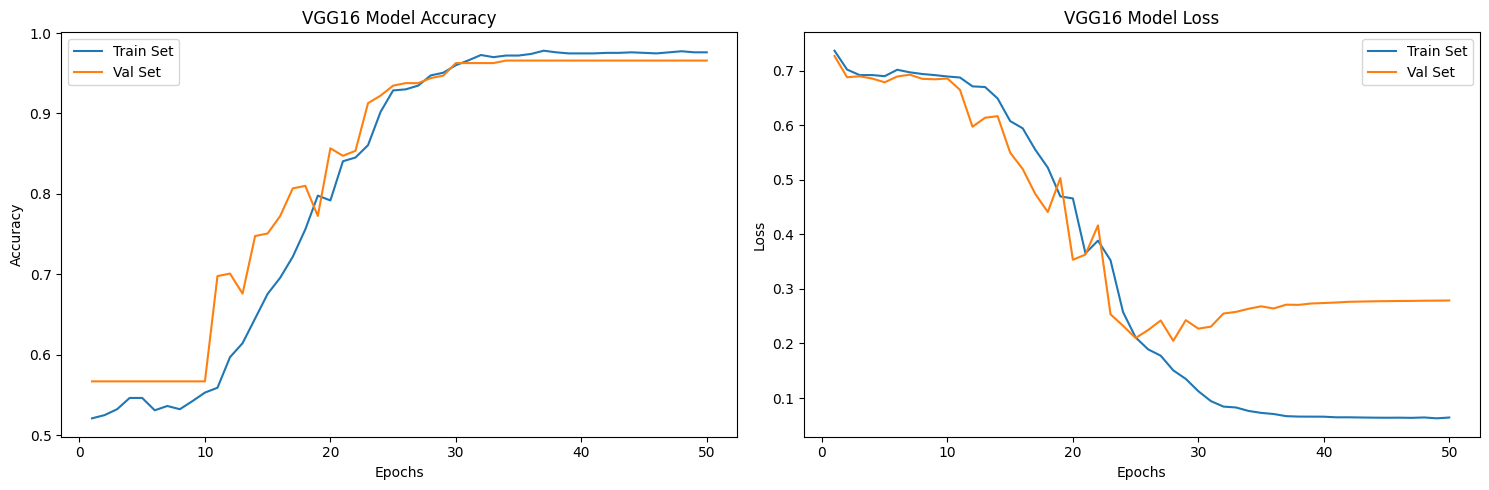

In [ ]:
# Step 11: Plotting accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Model Loss')
plt.tight_layout()
plt.show()

In [ ]:
mode=model.save('/content/drive/MyDrive/Monkey_Pox_Dataset/VGG16_MonkeyPox_Model.h5/')

In [ ]:
# Step 12: Evaluate the model on the validation set
val_score = model.evaluate(x_val, y_val)
print('Validation Loss:', val_score[0])
print('Validation Accuracy:', val_score[1])

11/11 [==============================] - 6s 541ms/step - loss: 0.2787 - accuracy: 0.9657
Validation Loss: 0.2787095010280609
Validation Accuracy: 0.9657320976257324


In [ ]:
# Step 13: Evaluate the model on the test set
test_score = model.evaluate(x_test, y_test)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

11/11 [==============================] - 6s 537ms/step - loss: 0.3427 - accuracy: 0.9317
Test Loss: 0.342727929353714
Test Accuracy: 0.9316770434379578


11/11 [==============================] - 6s 530ms/step


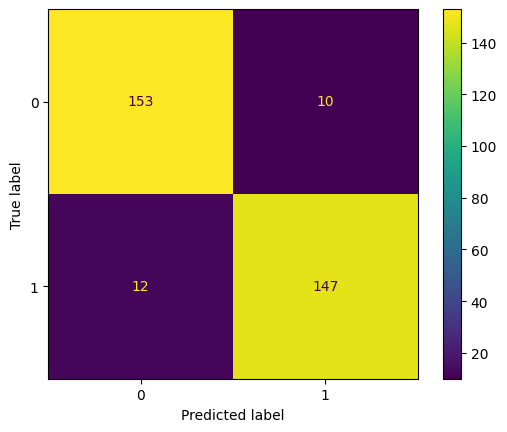

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       163
           1       0.94      0.92      0.93       159

    accuracy                           0.93       322
   macro avg       0.93      0.93      0.93       322
weighted avg       0.93      0.93      0.93       322



In [ ]:
# Step 14: Confusion matrix and classification report for test set
y_pred_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

CM_test = confusion_matrix(y_true_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=CM_test)
disp_test.plot()
plt.show()

print('Classification Report (Test Set):\n', classification_report(y_true_test, y_pred_test))

11/11 [==============================] - 6s 529ms/step


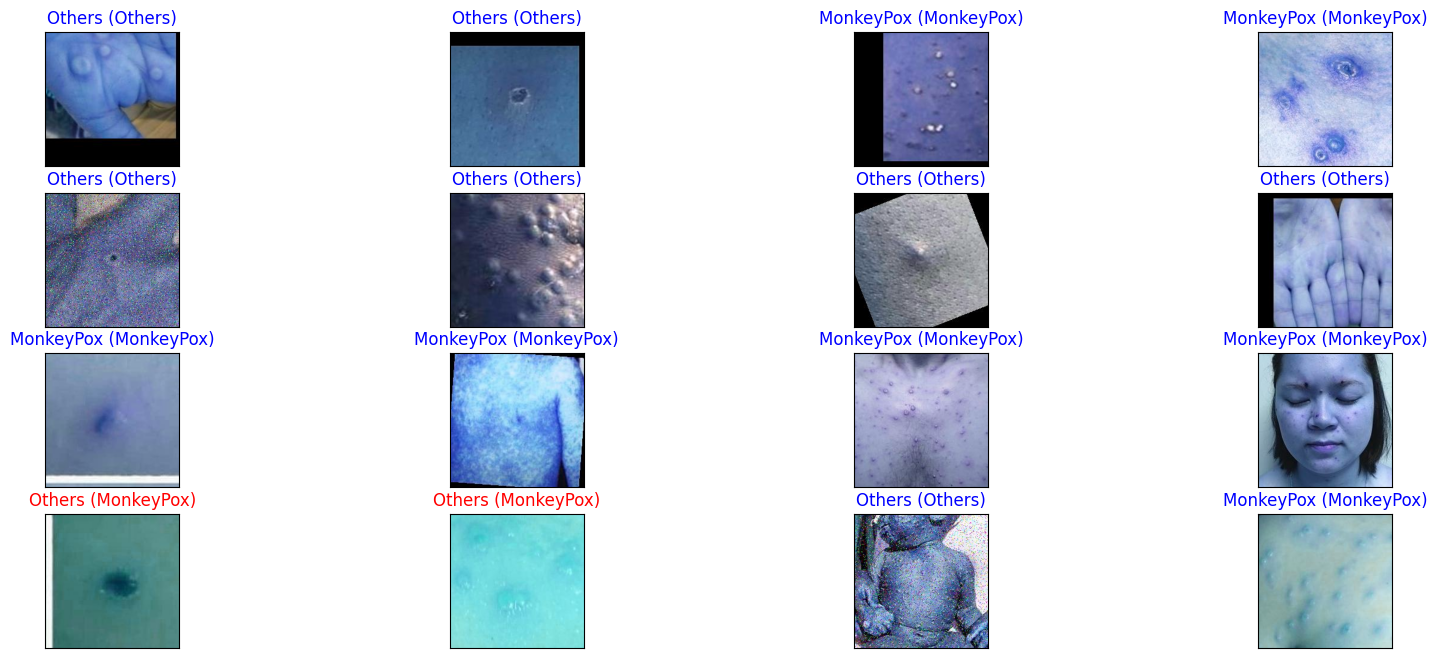

In [ ]:
# Step 15: Visualizing predictions on the test set
y_hat_test = model.predict(x_test)
labels_test = ['MonkeyPox', 'Others']

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat_test[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels_test[pred_idx], labels_test[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))